In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import multivariate_normal
import torch
from tqdm.notebook import tqdm

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [52]:
dataframe = pd.read_pickle('./results-updated.pkl')
dataframe

rows = dataframe.index.to_list()
rows = rows[:5] + rows[6:12] + rows[5:6] + rows[12:]
dataframe = dataframe.loc[rows]
rows = dataframe.index.to_list()
rows = rows[:2] + rows[4:5] + rows[2:4] + rows[7:8] + rows[5:7] + rows[10:11] + rows[8:10] + rows[11:]
dataframe = dataframe.loc[rows]
dataframe

,eq,eq-error,eq-iterations,eq-num-params,matern,matern-error,matern-iterations,matern-num-params,noisy-mixture,noisy-mixture-error,...,weakly-periodic,weakly-periodic-error,weakly-periodic-iterations,weakly-periodic-num-params,sawtooth,sawtooth-error,sawtooth-iterations,sawtooth-num-params,marker,colour
Oracle-GP,-1.467137,0.000078,NaN,NaN,-1.353008,0.000094,NaN,NaN,-1.138228,0.000164,...,-0.684042,0.000201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Oracle-GP-diag,-1.268017,0.000272,NaN,NaN,-1.051536,0.000325,NaN,NaN,-0.528327,0.000511,...,-0.044452,0.000423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GNP-meanfield,-0.638012,0.009875287677371985,101.0,116226.0,-0.754796,0.008464795480469658,101.0,116226.0,-1.443311,0.0036533837686370018,...,-1.256313,0.0025538157274956137,101.0,116226.0,-0.154716,0.0005410211294430628,101.0,116226.0,s,tab:blue
GNP-innerprod-homo,1.182211,0.0008531074924583836,101.0,182146.0,0.976542,0.0009482565899770122,101.0,182146.0,0.428077,0.0008661646281622737,...,-1.167704,0.0019287570131495428,101.0,182146.0,-0.154528,0.0005394041046926067,101.0,182146.0,o,tab:blue
GNP-kvv-homo,1.157327,0.0006542050623567252,101.0,182276.0,0.947542,0.000776251475802109,52.0,182276.0,0.450357,0.0007959569400274041,...,-1.16885,0.001935610096528121,101.0,182276.0,0.030203,0.00134215587623784,101.0,182276.0,x,tab:blue
AGNP-meanfield,1.007659,0.017391223522244915,101.0,739970.0,0.782967,0.018365342011694416,101.0,739970.0,-1.58463,0.002689849847729214,...,-0.531771,0.010744083730852535,101.0,739970.0,-0.154422,0.0005401464918619352,101.0,739970.0,s,tab:purple
AGNP-innerprod-homo,1.348338,0.00391724479032393,101.0,805890.0,1.218564,0.004655717560165192,101.0,805890.0,0.413861,0.006636657471307338,...,-1.183523,0.001884345616358144,101.0,805890.0,-0.154342,0.0005406391140800435,101.0,805890.0,o,tab:purple
AGNP-kvv-homo,1.332377,0.003563898271602679,101.0,806020.0,1.183141,0.003461377619894037,65.0,806020.0,0.718471,0.005549203592312926,...,-0.374576,0.008055266835525727,101.0,806020.0,0.001802,0.000980147276671583,13.0,806020.0,x,tab:purple
convGNP-meanfield,1.240592,0.010928441710968479,101.0,50700.0,1.037706,0.013368060923007363,101.0,50700.0,0.493567,0.021856075196736168,...,-0.299608,0.012680422813974562,101.0,50700.0,2.242457,0.013317000463821595,101.0,50700.0,s,tab:olive
convGNP-innerprod-homo,1.449473,0.002074954136633314,101.0,55300.0,1.280952,0.004429155090735151,101.0,55300.0,0.509286,0.0212606052417336,...,-0.313007,0.009078966398435808,101.0,55300.0,1.376293,0.02385173578236071,101.0,55300.0,o,tab:olive


In [53]:
def plot_all_toy_results(df):
    
    data_names = ["eq",
                  "matern",
                  "noisy-mixture",
#                   "noisy-mixture-slow",
                  "weakly-periodic",
#                   "weakly-periodic-slow",
                  "sawtooth"]
    
    titles = ["EQ",
              "Matern",
              "Noisy mixture",
#               "Noisy mixture (slow)",
              "Weakly periodic",
#               "Weakly periodic (slow)",
              "Sawtooth"]
    
    labels = ["GNP (meanfield)",
              "GNP (linear)",
              "GNP (kvv)",
              "AGNP (meanfield)",
              "AGNP (linear)",
              "AGNP (kvv)",
              "ConvGNP (meanfield)",
              "ConvGNP (linear)",
              "ConvGNP (kvv)",
              "ANP",
              "ConvNP",
              "FullConvGNP"]
    
    yticks = [np.linspace(-1.0, 1.5, 6),
              np.linspace(-1.0, 1.5, 6),
              np.linspace(-1.5, 1.0, 6),
              np.linspace(-1.5, 0.5, 5),
              np.linspace(-0.5, 2.5, 4)]
    
    markers = ["s", "s", "s"] + ["o", "o", "o"] + ["^", "^", "^"] + ["P", "X", "*"]
    triplet = [60., 60., 60.]
    marker_sizes = [60., 60., 50.] + [60., 60., 70.] + [60., 60., 80.] + [80.] + [80.] + [150.]
    
    triplet = ['tab:red', 'tab:green', 'tab:blue']
    colors = triplet * 3 + ["tab:purple"] + ["tab:purple"] + ["tab:orange"]
    
    fig = plt.figure(figsize=(14, 5))
    
    for i, d in enumerate(data_names):
        
        plt.subplot(1, len(data_names), i+1)
        
        x = np.arange(len(df[d]) + 2)
#         x = [x_ for i, x_ in enumerate(x)]
        ones = np.ones_like(x)
        y = df[d]
        e = df[d + '-error']
        oracle_result = df[d]["Oracle-GP"]
        oracle_error = df[d + "-error"]["Oracle-GP"]
        oracle_diag_result = df[d]["Oracle-GP-diag"]
        oracle_diag_error = df[d + "-error"]["Oracle-GP-diag"]

        for j in range(2, len(labels)+2):
            
            if i == len(data_names) - 1:
                plt.scatter(x[j], y[j], marker=markers[j-2], s=marker_sizes[j-2], color=colors[j-2], linewidth=0.6, edgecolor='k', zorder=2, label=labels[j-2])
#                 plt.errorbar(x[j], y[j], e[j], marker=markers[j-2], color=colors[j-2], linewidth=1.2, zorder=1)
            
            else:
                plt.scatter(x[j], y[j], marker=markers[j-2], s=marker_sizes[j-2], color=colors[j-2], linewidth=0.6, edgecolor='k', zorder=2)
#                 plt.errorbar(x[j], y[j], e[j], marker=markers[j-2], color=colors[j-2], linewidth=1.2, zorder=1)
#                 plt.setp(axis, ylim=axis[0].get_ylim())
                
#         for j in range(3):
#             idx = 2 + j + np.arange(0, 7, 3)
#             plt.plot(idx, y[idx], color='gray', zorder=1, alpha=0.3)

        plt.plot(x, -oracle_result * ones, '--', label='GP Oracle', color='k', zorder=1)
        plt.plot(x, -oracle_diag_result * ones, '--', label='GP Oracle (diag.)', color='tab:red', zorder=1)

        plt.xticks([])
        plt.title(titles[i], fontsize=18)
        plt.xlim([0., 14])
        
        if i == 0:
            plt.ylabel('Log. likelihood', fontsize=24)
    
        ylims = [(-1.10, 1.65),
                 (-1.10, 1.53),
                 (-1.75, 1.35),
                 (-1.75, 0.90),
                 (-0.60, 2.6)]
            
        plt.yticks(yticks[i], fontsize=14)
        plt.ylim(ylims[i])
        
        
    handles, labels = plt.gca().get_legend_handles_labels()
#     fig.legend(handles[:2], labels[:2], loc='right', ncol=2, fontsize=13)

    fig.legend(handles[:2], labels[:2], loc='lower left', ncol=1, fontsize=14, bbox_to_anchor=(0.02, 0.015, 0.10, 0.10))
    fig.legend(handles[2:], labels[2:], loc='center', ncol=4, fontsize=14, bbox_to_anchor=(0.4, 0.0, 0.4, 0.2))

    plt.tight_layout()
    fig.subplots_adjust(bottom=0.22)
    plt.savefig("./plots/toy-results.pdf")
    plt.show()

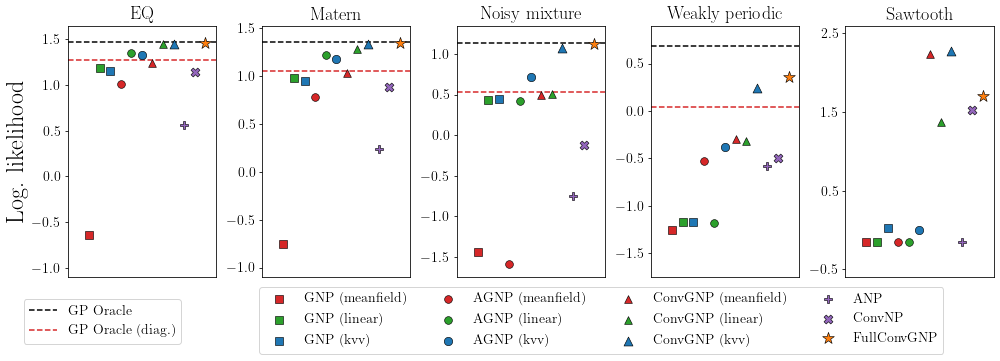

In [54]:
plot_all_toy_results(dataframe)